# Navigator Error Corrected Triangulation

This notebook demonstrates the triangulation with tropospheric and ionospheric corrections using the Navigator library.

In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path

Load the data from JPLM00USA GNSS station.

In [2]:
from pathlib import Path

obs_path = Path("./data/JPLM00USA_R_20223230000_01D_30S_MO.crx.gz")
nav_path = Path("./data/JPLM00USA_R_20223230000_01D_GN.rnx.gz")

Convert the rinex files into epoches for processing with navigator library.

In [3]:
from navigator.epoch import Epoch
epoches = list(Epoch.epochify(obs_path, nav_path))

Linearly sort the epoch with respect to time.

In [4]:
epoches.sort()
epoches = [epoch for epoch in epoches if len(epoch) > 4]

# Test epoches
num_epochs = 1000
test_epoches = epoches[:num_epochs]

Now we can use the navigator library to process the data with WLS method.

In [5]:
from navigator.core import Triangulate, IterativeTriangulationInterface

triangulator = Triangulate(interface=IterativeTriangulationInterface())

Now to triangulate the position of the GNSS station, we can use the navigator.core module to calculate the position of the station. As this is a know IGS station, we can compare the calculated position with the known position. The triangulation interface is similar to previous examples. However, a new ablity to process timeseries data is added. This feature takes a list of epoches and processes them in a single call.

### **Dual Frequency Triangulation**

To triangulate the dual frequency, one needs dual frequency reciever which can recieve both L1 and L2 signals. The ionosphere free combination of L1 and L2 signals can be used to eliminate the ionospheric error. The tropospheric error can be eliminated by approximating using known models.[See here](../../src/navigator/core/triangulate/itriangulate/algos/troposphere/egnos_tropospheric_correction_model.py) 

In [6]:
# DUAL FREQUENCY TRIANGULATION WITH TROPOSPHERIC AND IONOSPHERIC CORRECTION
df_dual = triangulator.triangulate_time_series(
    epochs=test_epoches, # Pass the list of epoches
    mode="dual", # Select the dual frequency mode
    apply_tropo=True, # Flag to apply tropospheric correction
    apply_iono=True # Flag to apply ionospheric correction
)

# DUAl FREQUENCY WITHOUT TROPOSPHERIC CORRECTION
df_dual_no_tropr = triangulator.triangulate_time_series(
    epochs=test_epoches, # Pass the list of epoches 
    mode="dual", # Select the dual frequency mode
    apply_tropo=False, # Do not apply tropospheric correction
    apply_iono=True # Iono correction is applied since the dual frequency mode is selected
)

Triangulating: 100%|██████████| 1000/1000 [00:17<00:00, 57.60it/s]


### **Single Frequency Triangulation**

The single frequency triangulation can be done using the navigator library. The Kloubuchar Iono model is used to eliminate the ionospheric error. The tropospheric error can be eliminated by approximating using known models.[See here](../../src/navigator/core/triangulate/itriangulate/algos/troposphere/egnos_tropospheric_correction_model.py)

In [7]:
# SINGLE FREQUENCY TRIANGULATION WITH TROPOSPHERIC AND IONOSPHERIC CORRECTION
df_single = triangulator.triangulate_time_series(
    epochs=test_epoches,
    mode="single", # Select the single frequency mode
    apply_tropo=True, # Flag to apply tropospheric correction
    apply_iono=True # Flag to apply ionospheric correction [Note this needs the navigation metadata to be present in the epoch object since part of the ionospheric correction is done using the navigation data]
)

# SINGLE FREQUENCY NO IONOSPHERIC CORRECTION
df_single_no_ion = triangulator.triangulate_time_series(
    epochs=test_epoches,
    mode="single", # Select the single frequency mode
    apply_tropo=True, # Apply tropospheric correction
    apply_iono=False # Do not apply ionospheric correction
)

# SINGLE FREQUENCY WITHOUT TROPOSPHERIC CORRECTION
df_single_no_tropo = triangulator.triangulate_time_series(
    epochs=test_epoches,
    mode="single", # Select the single frequency mode
    apply_tropo=False, # Do not apply tropospheric correction
    apply_iono=True # Apply ionospheric correction [Note this needs the navigation metadata to be present in the epoch object since part of the ionospheric correction is done using the navigation data]
)

# SINGLE FREQUENCY NO TROPOSPHERIC AND IONOSPHERIC CORRECTION
df_single_no_tropo_ion = triangulator.triangulate_time_series(
    epochs=test_epoches,
    mode="single", # Select the single frequency mode
    apply_tropo=False, # Do not apply tropospheric correction
    apply_iono=False # Do not apply ionospheric correction
)

Triangulating: 100%|██████████| 1000/1000 [00:16<00:00, 58.95it/s]


### **Comparison of all modes of triangulation**

Let's compare all the mode of triangulation and see the difference in the position of the GNSS station.

#### **Error Difference Plots**

The time series plots if the elucidian distance between the known position and the calculated position for all the modes of triangulation is plotted.

Text(0.5, 1.0, 'Triangulation Error')

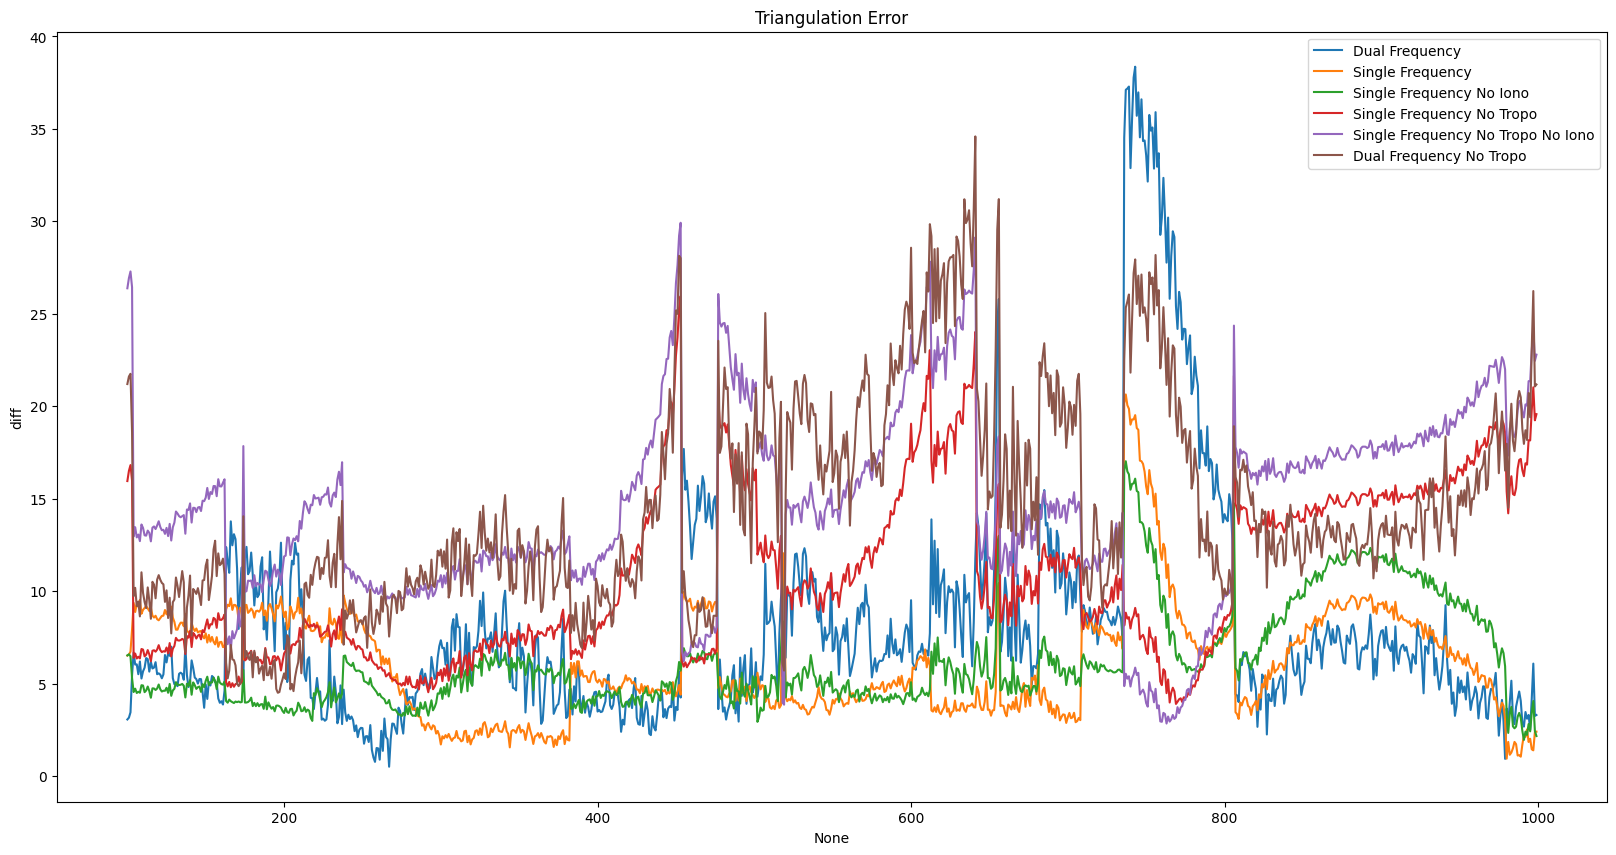

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
n = 100
plt.figure(figsize=(20, 10))
ax = sns.lineplot(x=df_dual.index[n:], y=df_dual["diff"][n:], label="Dual Frequency")
ax = sns.lineplot(x=df_single.index[n:], y=df_single["diff"][n:], label="Single Frequency")
ax = sns.lineplot(x=df_single_no_ion.index[n:], y=df_single_no_ion["diff"][n:], label="Single Frequency No Iono")
ax = sns.lineplot(x=df_single_no_tropo.index[n:], y=df_single_no_tropo["diff"][n:], label="Single Frequency No Tropo")
ax = sns.lineplot(x=df_single_no_tropo_ion.index[n:], y=df_single_no_tropo_ion["diff"][n:], label="Single Frequency No Tropo No Iono")
ax = sns.lineplot(x=df_dual_no_tropr.index[n:], y=df_dual_no_tropr["diff"][n:], label="Dual Frequency No Tropo")

ax.set_title("Triangulation Error")

#### **Error Distribution Plots**

The probability distribution of the error in the position of the GNSS station is plotted for all the modes of triangulation.

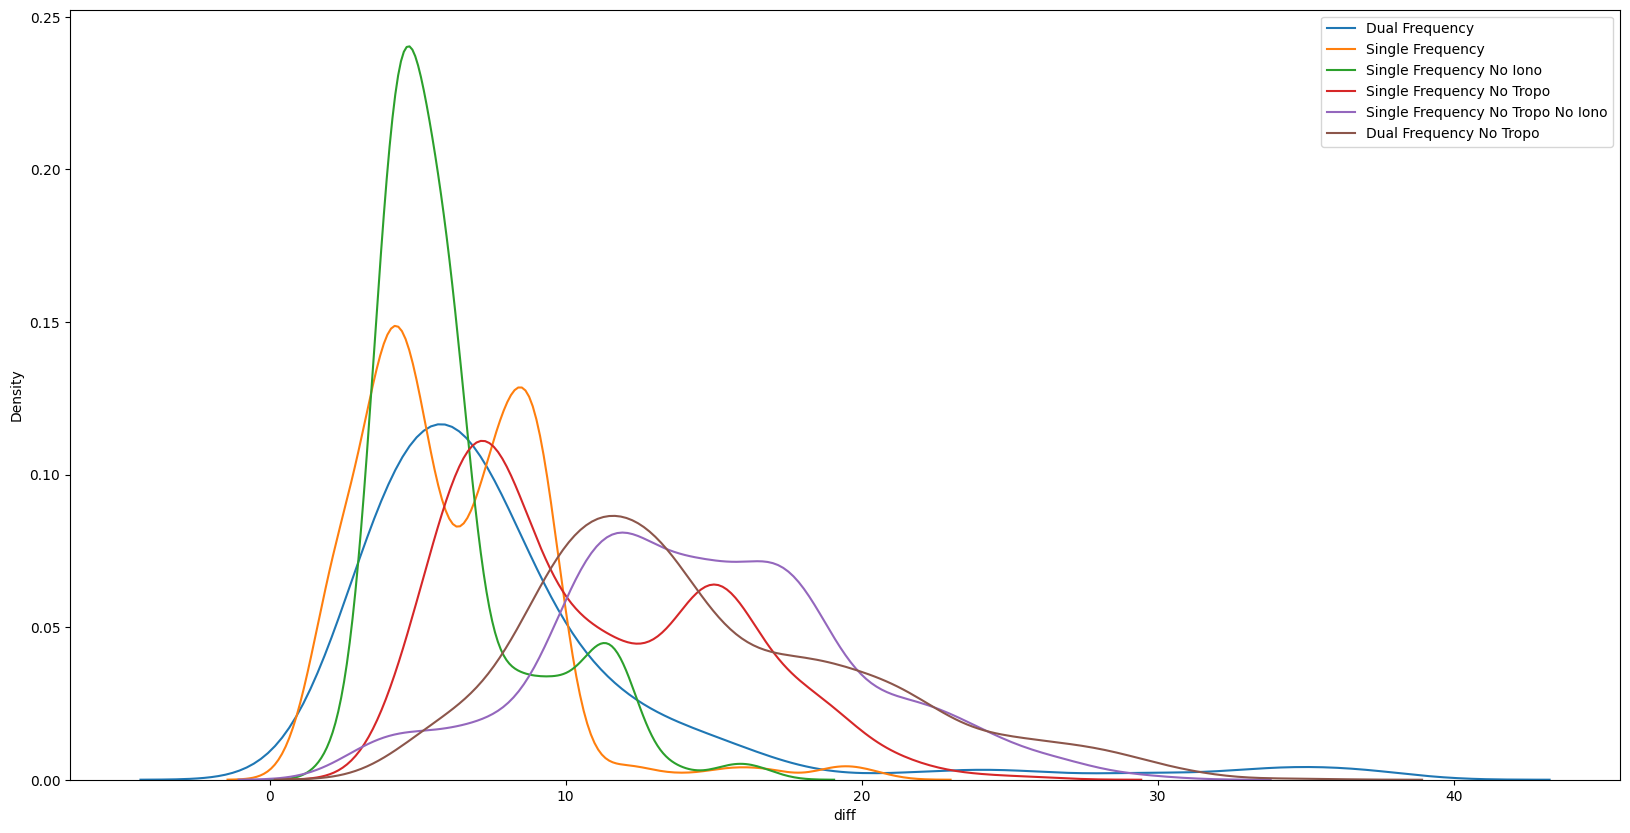

In [9]:
# Error Distribution of each modes
plt.figure(figsize=(20, 10))

# Do a KDE plot
ax = sns.kdeplot(df_dual["diff"][n:], label="Dual Frequency")
ax = sns.kdeplot(df_single["diff"][n:], label="Single Frequency", ax=ax)
ax = sns.kdeplot(df_single_no_ion["diff"][n:], label="Single Frequency No Iono", ax=ax)
ax = sns.kdeplot(df_single_no_tropo["diff"][n:], label="Single Frequency No Tropo", ax=ax)
ax = sns.kdeplot(df_single_no_tropo_ion["diff"][n:], label="Single Frequency No Tropo No Iono", ax=ax)
ax = sns.kdeplot(df_dual_no_tropr["diff"][n:], label="Dual Frequency No Tropo", ax=ax)

# Legend
plt.legend()



### **Conclusion**

To conclude this experiment, we can say that the dual frequency triangulation with tropospheric and ionospheric corrections is good model since it consistently gives under 5m accuracy. The tropospheric error seem to be major source of error that needs to be corrected. Suprisingly, the single frequency triangulation with just tropospheric correction gives better accuracy than the single frequency triangulation with ionospheric correction. This might be due to the crude approximation of the ionospheric error using the Kloubuchar model. Further investigation is needed to understand the impact of the ionospheric error on the triangulation.

We conclude that the navigator module is able to achieve triangulation withim <5m accuracy.